In [23]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from keras.utils import to_categorical
from keras.utils import img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import math
import datetime
import time

In [24]:
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Default dimensions we found online
img_width, img_height = 224, 224

# Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model_alexnet.h5'

# Loading up our datasets
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

# Number of epochs to train top model
epochs = 100  # This has been changed after multiple model runs
# Batch size used by flow_from_directory and predict_generator
batch_size = 50

In [25]:
# Load pre-trained AlexNet model in PyTorch
pytorch_model = models.alexnet(pretrained=True)

# Modify the last layer for feature extraction
num_ftrs = pytorch_model.classifier[6].in_features
pytorch_model.classifier[6] = nn.Identity()

# Define transforms for images
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_data_dir, transform=transform)
validation_dataset = ImageFolder(validation_data_dir, transform=transform)
test_dataset = ImageFolder(test_data_dir, transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Feature extraction for training data
start = datetime.datetime.now()
train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        features = pytorch_model(images)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)
np.save('train_features_alex.npy', train_features.numpy())
np.save('train_labels_alex.npy', train_labels.numpy())
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction time for training data:', elapsed)

# Feature extraction for validation data
start = datetime.datetime.now()
validation_features = []
validation_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        features = pytorch_model(images)
        validation_features.append(features)
        validation_labels.append(labels)

validation_features = torch.cat(validation_features)
validation_labels = torch.cat(validation_labels)
np.save('validation_features_alex.npy', validation_features.numpy())
np.save('validation_labels_alex.npy', validation_labels.numpy())
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction time for validation data:', elapsed)

# Feature extraction for test data
start = datetime.datetime.now()
test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        features = pytorch_model(images)
        test_features.append(features)
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)
np.save('test_features_alex.npy', test_features.numpy())
np.save('test_labels_alex.npy', test_labels.numpy())
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction time for test data:', elapsed)

# Load features and labels
train_data = np.load('train_features_alex.npy')
train_labels = np.load('train_labels_alex.npy')
validation_data = np.load('validation_features_alex.npy')
validation_labels = np.load('validation_labels_alex.npy')
test_data = np.load('test_features_alex.npy')
test_labels = np.load('test_labels_alex.npy')

# Convert target labels to one-hot encoded format
train_labels = to_categorical(train_labels, num_classes=20)
validation_labels = to_categorical(validation_labels, num_classes=20)
test_labels = to_categorical(test_labels, num_classes=20)

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extraction time for training data: 0:00:21.380970
Feature extraction time for validation data: 0:00:02.317891
Feature extraction time for test data: 0:00:02.460165


In [26]:
# Define the model architecture
from keras import regularizers
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation=keras.layers.LeakyReLU(
    alpha=0.3), kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=keras.layers.LeakyReLU(
    alpha=0.3), kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.4))
model.add(Dense(units=20, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

early_stopping = EarlyStopping(
    monitor='val_acc', patience=20, verbose=1, mode='max')

# Train the model
history = model.fit(train_data, train_labels,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[early_stopping])

# Save the trained model
model.save_weights(top_model_weights_path)

# Evaluate the model on the test data
(eval_loss, eval_accuracy) = model.evaluate(
    test_data, test_labels, batch_size=batch_size, verbose=1)

# Print the evaluation results
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

Epoch 1/200


c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


31/31 [==============================] - 1s 24ms/step - loss: 4.0861 - acc: 0.1536 - val_loss: 1.6615 - val_acc: 0.5549
Epoch 2/200
31/31 [==============================] - 1s 20ms/step - loss: 1.9366 - acc: 0.4825 - val_loss: 1.1152 - val_acc: 0.7500
Epoch 3/200
31/31 [==============================] - 1s 20ms/step - loss: 1.2844 - acc: 0.6394 - val_loss: 0.9441 - val_acc: 0.7622
Epoch 4/200
31/31 [==============================] - 1s 24ms/step - loss: 0.9960 - acc: 0.7284 - val_loss: 0.8577 - val_acc: 0.7927
Epoch 5/200
31/31 [==============================] - 1s 19ms/step - loss: 0.8072 - acc: 0.7917 - val_loss: 0.8061 - val_acc: 0.8232
Epoch 6/200
31/31 [==============================] - 1s 20ms/step - loss: 0.6609 - acc: 0.8260 - val_loss: 0.7725 - val_acc: 0.8049
Epoch 7/200
31/31 [==============================] - 1s 20ms/step - loss: 0.5554 - acc: 0.8576 - val_loss: 0.7624 - val_acc: 0.8232
Epoch 8/200
31/31 [==============================] - 1s 19ms/step - loss: 0.4993 - acc: 

In [27]:
filepath = 'model_save_alexnet.h5'
keras.models.save_model(model, filepath)

In [28]:
model.save('savealexnet.h5')

In [29]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               2097664   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 20)                2580      
                                                                 
Total params: 2,165,908
Trainable params: 2,165,908
No

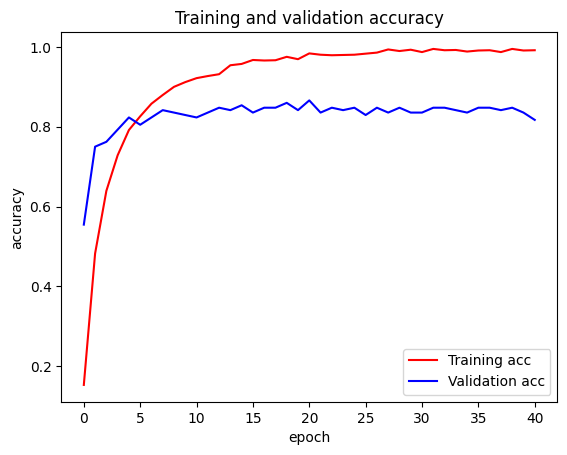

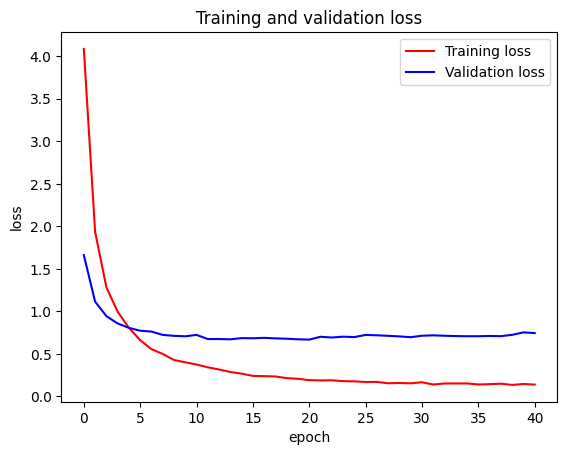

In [30]:
# Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [31]:
model.evaluate(test_data, test_labels)

6/6 [==============================] - 0s 5ms/step - loss: 0.8207 - acc: 0.8232


[0.8206566572189331, 0.8231707215309143]

In [32]:
print('test data', test_data)
preds = np.round(model.predict(test_data), 0)
# to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[0.         0.         0.38541913 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         3.4683712  ... 1.9456716  0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
6/6 [==============================] - 0s 6ms/step
rounded test_labels [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [33]:
animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat',
           'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']
classification_metrics = metrics.classification_report(
    test_labels, preds, target_names=animals)
print(classification_metrics)

              precision    recall  f1-score   support

        bear       0.90      0.90      0.90        10
      cougar       0.67      0.20      0.31        10
      coyote       1.00      0.80      0.89        10
         cow       0.89      0.80      0.84        10
  crocodiles       1.00      1.00      1.00        10
        deer       0.78      0.70      0.74        10
    elephant       0.88      0.70      0.78        10
     giraffe       0.86      1.00      0.92         6
        goat       0.78      0.78      0.78         9
     gorilla       0.86      1.00      0.92         6
       horse       1.00      1.00      1.00        10
    kangaroo       0.60      0.86      0.71         7
     leopard       1.00      0.80      0.89        10
        lion       0.88      0.78      0.82         9
       panda       1.00      0.88      0.93         8
     penguin       0.71      1.00      0.83         5
       sheep       1.00      0.80      0.89         5
       skunk       1.00    

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
# Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [35]:
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 8)):  # Adjust the figsize as per your preference
    # Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Set figure size
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    # Rotate x-labels by 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Increase x-coordinate for more horizontal space
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


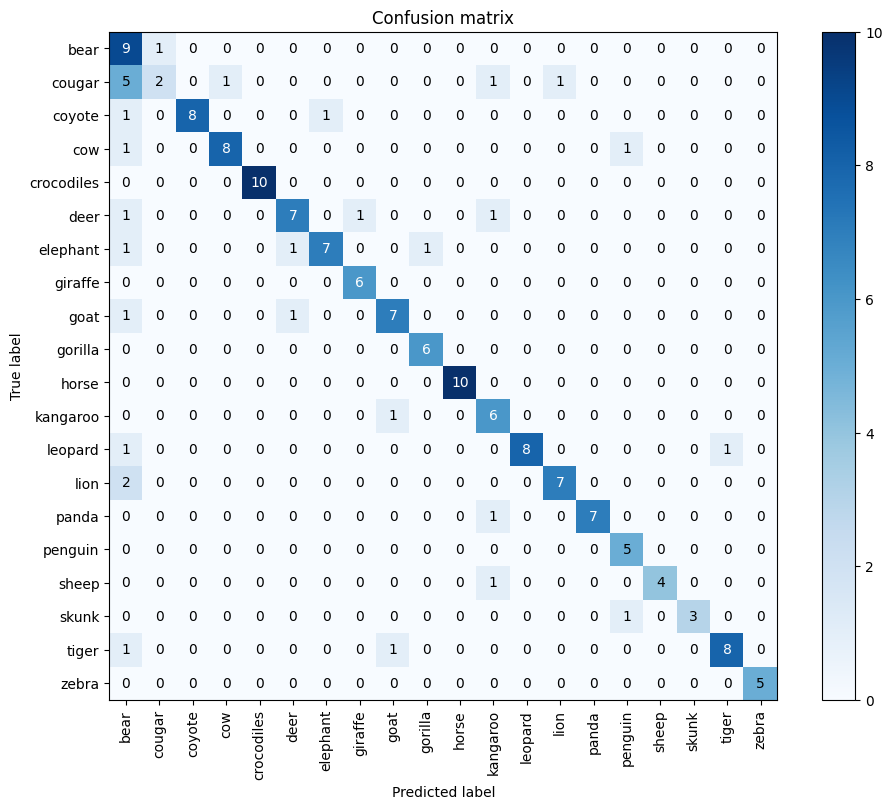

In [37]:
plot_confusion_matrix(confusion_matrix, ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe',
                      'goat', 'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'])

Normalized confusion matrix


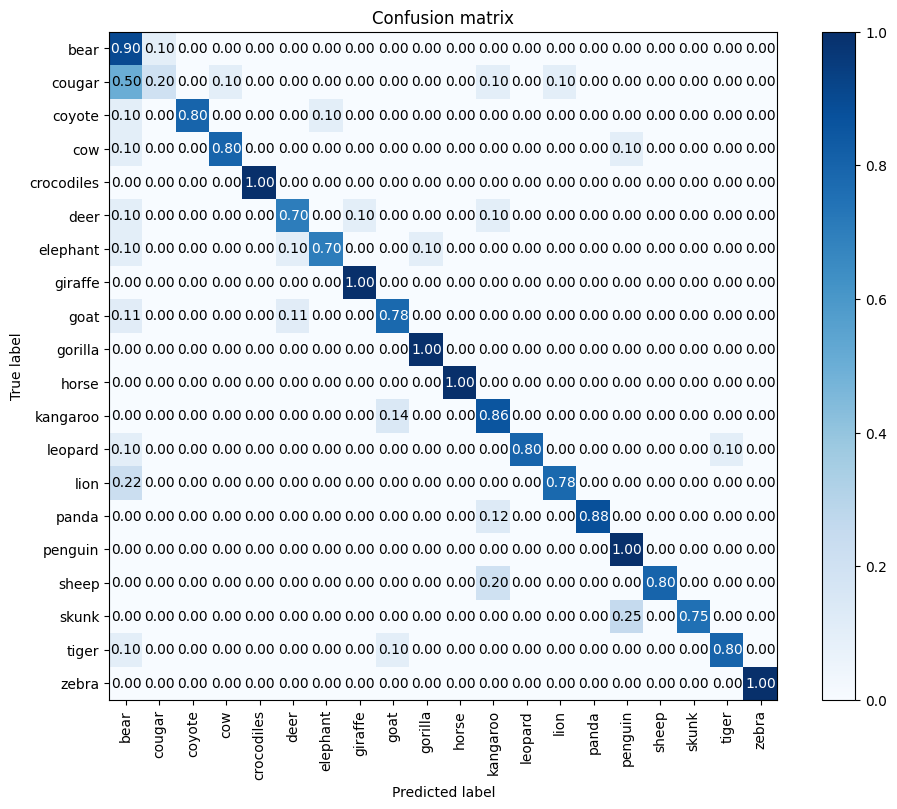

In [38]:
# Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix,
                      ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat', 'gorilla',
                          'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'],
                      normalize=True)

In [39]:
model.load_weights(top_model_weights_path)

In [40]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.
    return image

In [41]:
def test_single_image(path):
    animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat',
               'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']
    image = read_image(path)
    time.sleep(.5)
    image = torch.tensor(image, dtype=torch.float32)
    # Change the dimension order to [batch_size, channels, height, width]
    image = image.permute(0, 3, 1, 2)
    image = image.to('cpu')  # Set to 'cuda' if you're using GPU
    features = pytorch_model(image)
    features = features.detach().numpy()
    preds = model.predict(features)
    # print("BT ",bt_prediction)
    for idx, animal, x in zip(range(0, 20), animals, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100, 2)))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_prob = list(preds[0])
    max_prob = max(class_prob)
    pred_class = class_prob.index(max_prob)
    print("ID: {}, Label: {}".format(pred_class, animals[pred_class]))
    return load_img(path)

In [42]:
path = 'data/test/gorilla/4_74.jpg'

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 37ms/step
ID: 0, Label: bear 14.89%
ID: 1, Label: cougar 0.44%
ID: 2, Label: coyote 24.88%
ID: 3, Label: cow 0.0%
ID: 4, Label: crocodiles 0.5%
ID: 5, Label: deer 0.01%
ID: 6, Label: elephant 23.05%
ID: 7, Label: giraffe 0.03%
ID: 8, Label: goat 0.01%
ID: 9, Label: gorilla 4.2%
ID: 10, Label: horse 0.0%
ID: 11, Label: kangaroo 9.01%
ID: 12, Label: leopard 0.07%
ID: 13, Label: lion 0.13%
ID: 14, Label: panda 0.02%
ID: 15, Label: penguin 0.05%
ID: 16, Label: sheep 22.19%
ID: 17, Label: skunk 0.02%
ID: 18, Label: tiger 0.03%
ID: 19, Label: zebra 0.47%
Final Decision:
.
..
...
ID: 2, Label: coyote


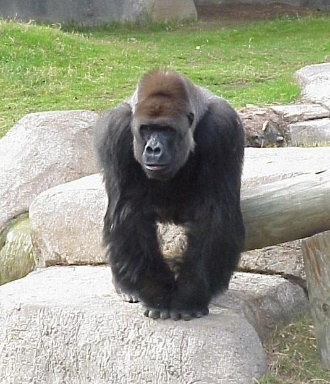

In [43]:
test_single_image(path)

In [44]:
from sklearn import metrics

# Compute precision, recall, F1 score
precision = metrics.precision_score(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1), average='weighted')
recall = metrics.recall_score(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1), average='weighted')
f1_score = metrics.f1_score(np.argmax(test_labels, axis=1), np.argmax(
    preds, axis=1), average='weighted')

# Compute confusion matrix
conf_matrix = metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))

# Calculate FAR and FRR
far = np.sum(conf_matrix.sum(axis=0) - np.diag(conf_matrix)) / \
    np.sum(conf_matrix.sum(axis=1))
frr = np.sum(conf_matrix.sum(axis=1) - np.diag(conf_matrix)) / \
    np.sum(conf_matrix.sum(axis=1))

# Print out the results
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))
print("False Acceptance Rate (FAR): {:.2f}".format(far))
print("False Rejection Rate (FRR): {:.2f}".format(frr))

# Calculate mAP
average_precision = metrics.average_precision_score(
    test_labels, preds, average=None)
mAP = np.mean(average_precision)
print("Mean Average Precision (mAP): {:.2f}".format(mAP))

Accuracy: 82.32%
Precision: 0.85
Recall: 0.81
F1 Score: 0.81
False Acceptance Rate (FAR): 0.19
False Rejection Rate (FRR): 0.19
Mean Average Precision (mAP): 0.75
